 # 📊 EDA Completa – Base Tratada de Churn Bancário



 Notebook-script para VSCode (Python + Jupyter) usando a base:

 `data/base_tratada.csv`



 Objetivos:

 - Carregar a base tratada

 - Verificar qualidade dos dados

 - Explorar distribuições (numéricas e categóricas)

 - Analisar outliers

 - Ver correlações com o target

 - Fazer PCA e clusterização

 - Preparar base final de modelagem (`base_modelagem.csv`)



 Execute célula a célula no VSCode (Run Cell) para uma análise didática.

 ## 0. Imports e Configurações Iniciais

In [1]:
from pathlib import Path
import warnings
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy import stats

# Tentativa de importar statsmodels (opcional)
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False
    variance_inflation_factor = None
    add_constant = None

# Tentativa de importar plotly (opcional)
try:
    import plotly.express as px
    HAS_PLOTLY = True
except ImportError:
    HAS_PLOTLY = False

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1200)

TARGET_COL = "Attrition"

print("✅ Imports concluídos.")


✅ Imports concluídos.


 ## 1. Funções Utilitárias de Data Quality e EDA

In [2]:
def data_quality_report(df, save_path=None):
    """
    Verificações rápidas de qualidade de dados e, opcionalmente,
    salva a base tratada em CSV.
    """
    if df is None:
        raise ValueError("DataFrame 'df' não foi fornecido (None).")

    print("\n🔍 Verificação de Data Quality:")
    print(f"- Registros: {len(df)}")
    print(f"- Duplicados: {df.duplicated().sum()} registros")

    mem_mb = df.memory_usage(deep=True).sum() / 1024**2
    print(f"- Memória usada: {mem_mb:.2f} MB")

    # Colunas constantes
    constant_cols = [col for col in df.columns if df[col].nunique(dropna=False) == 1]
    if constant_cols:
        print(f"- Colunas constantes: {constant_cols}")
    else:
        print("- Colunas constantes: nenhuma")

    # Missing values
    total_missing = df.isnull().sum().sum()
    print(f"- Valores ausentes (total): {total_missing}")
    if total_missing:
        missing_per_col = df.isnull().sum()
        top_missing = (
            missing_per_col[missing_per_col > 0]
            .sort_values(ascending=False)
            .head(10)
        )
        print("- Top colunas com NA:")
        for col, cnt in top_missing.items():
            pct = cnt / len(df) * 100
            print(f"    - {col}: {cnt} ({pct:.2f}%)")

    # Zeros em colunas numéricas
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    zero_counts = {c: int((df[c] == 0).sum()) for c in num_cols if (df[c] == 0).any()}
    if zero_counts:
        print("- Contagens de zeros em colunas numéricas (até 10):")
        for i, (col, cnt) in enumerate(
            sorted(zero_counts.items(), key=lambda x: -x[1])
        ):
            if i >= 10:
                break
            print(f"    - {col}: {cnt}")

    # Salvar arquivo tratado opcionalmente
    if save_path:
        p = Path(save_path)
        p.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(p, index=False)
        print(f"- Base salva em: {p.resolve()}")


def detect_outliers_iqr(df, column, threshold=1.5):
    """Detecta outliers usando o método IQR (quartis)."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - threshold * IQR
    upper = Q3 + threshold * IQR

    outliers = df[(df[column] < lower) | (df[column] > upper)]
    outlier_pct = len(outliers) / len(df) * 100

    return {
        "outlier_count": int(len(outliers)),
        "outlier_percentage": float(outlier_pct),
        "lower_bound": float(lower),
        "upper_bound": float(upper),
        "Q1": float(Q1),
        "Q3": float(Q3),
        "IQR": float(IQR),
        "min": float(df[column].min()),
        "max": float(df[column].max()),
        "mean": float(df[column].mean()),
        "median": float(df[column].median()),
    }


def detailed_statistical_comparison(df, numeric_cols, target_col=TARGET_COL):
    """Compara estatísticas das variáveis numéricas entre as classes do target."""
    stats_comparison = pd.DataFrame()

    for col in numeric_cols:
        # Estatísticas por grupo
        group_stats = df.groupby(target_col)[col].agg(
            [
                "mean",
                "median",
                "std",
                "min",
                "max",
                "skew",
                lambda x: x.quantile(0.75) - x.quantile(0.25),
            ]
        ).rename(columns={"<lambda_0>": "IQR"})

        group0 = df[df[target_col] == 0][col].dropna()
        group1 = df[df[target_col] == 1][col].dropna()

        if len(group0) > 1 and len(group1) > 1:
            t_stat, p_value = stats.ttest_ind(group0, group1, equal_var=False)
        else:
            t_stat, p_value = np.nan, np.nan

        cv0 = group0.std() / group0.mean() if group0.mean() != 0 else np.nan
        cv1 = group1.std() / group1.mean() if group1.mean() != 0 else np.nan

        stats_comparison[col] = {
            "t_statistic": t_stat,
            "p_value": p_value,
            "mean_diff": group_stats.loc[1, "mean"] - group_stats.loc[0, "mean"],
            "cv_0": cv0,
            "cv_1": cv1,
        }

    return stats_comparison.T


def significant_correlations(df, cols, target_col=TARGET_COL, alpha=0.05):
    """Calcula correlação de Pearson + p-valor entre features numéricas e o target."""
    results = []
    for col in cols:
        if col == target_col:
            continue

        x = df[col].dropna()
        y = df[target_col].loc[x.index].dropna()

        if len(x) > 1 and len(y) > 1:
            corr, p_value = stats.pearsonr(x, y)
        else:
            corr, p_value = np.nan, np.nan

        results.append(
            {
                "feature": col,
                "correlation": corr,
                "p_value": p_value,
                "significant": bool(p_value < alpha)
                if not np.isnan(p_value)
                else False,
                "abs_correlation": abs(corr) if not np.isnan(corr) else np.nan,
            }
        )

    return pd.DataFrame(results).sort_values("abs_correlation", ascending=False)


def calculate_vif(df, numeric_cols):
    """Calcula VIF (Variance Inflation Factor) para avaliar multicolinearidade."""
    if not HAS_STATSMODELS:
        raise ImportError(
            "statsmodels não está instalado. Instale com: pip install statsmodels"
        )

    X = add_constant(df[numeric_cols].dropna())
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    return vif_data.sort_values("VIF", ascending=False)


def pca_3d_visualization(X_scaled, target, n_components=3):
    """PCA em 3D para visualização dos clientes coloridos por churn."""
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    scatter = ax.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        X_pca[:, 2],
        c=target,
        cmap="viridis",
        alpha=0.6,
        s=15,
    )

    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
    ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]:.1%})")
    plt.title("PCA 3D - Clientes por Status de Churn")
    plt.legend(*scatter.legend_elements(), title="Churn")
    plt.tight_layout()
    plt.show()

    return X_pca, pca


def elbow_method(X_scaled, max_clusters=10):
    """Método do cotovelo para escolher k no KMeans."""
    inertias = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), inertias, marker="o")
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("Inércia (Within-Cluster SSE)")
    plt.title("Método do Cotovelo para KMeans")
    plt.grid(True)
    plt.show()


def silhouette_analysis(X_scaled, max_clusters=10):
    """Silhouette score por número de clusters."""
    scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        scores.append(score)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), scores, marker="o", color="tab:red")
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Análise de Silhouette para KMeans")
    plt.grid(True)
    plt.show()


def generate_eda_report(df, target_col=TARGET_COL):
    """Gera um dicionário com resumo de EDA para exportar em JSON."""
    report = {
        "dataset_shape": df.shape,
        "target_distribution": df[target_col].value_counts().to_dict()
        if target_col in df.columns
        else None,
        "missing_values_total": int(df.isnull().sum().sum()),
        "duplicates": int(df.duplicated().sum()),
        "numeric_features": df.select_dtypes(include=[np.number]).columns.tolist(),
        "categorical_features": df.select_dtypes(include=["object"]).columns.tolist(),
    }

    report["numeric_stats"] = df.describe().T.to_dict()

    if target_col in df.columns:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        correlations = (
            df[numeric_cols].corr()[target_col].sort_values(ascending=False)
        )
        report["top_correlations"] = correlations.head(10).to_dict()

    return report


def export_analysis_results(df, cluster_labels, pca_result, output_dir="eda_results"):
    """Exporta resultados principais de EDA para CSVs em uma pasta."""
    import os

    os.makedirs(output_dir, exist_ok=True)

    df_export = df.copy()
    if cluster_labels is not None:
        df_export["Cluster"] = cluster_labels
    if pca_result is not None and pca_result.shape[1] >= 2:
        df_export["PC1"] = pca_result[:, 0]
        df_export["PC2"] = pca_result[:, 1]

    df_export.to_csv(f"{output_dir}/dataset_with_clusters.csv", index=False)

    df.describe().to_csv(f"{output_dir}/statistical_summary.csv")

    print(f"✅ Resultados exportados para '{output_dir}/'")


def interactive_distribution(df, col, target_col=TARGET_COL):
    """Histograma interativo por classe (se Plotly estiver instalado)."""
    if not HAS_PLOTLY:
        print("⚠️ Plotly não está instalado. Use: pip install plotly")
        return

    fig = px.histogram(
        df,
        x=col,
        color=target_col,
        marginal="box",
        nbins=50,
        barmode="overlay",
        opacity=0.7,
        title=f"Distribuição de {col} por Churn",
    )
    fig.show()


def visualize_outliers(df, column, target_col=TARGET_COL, outlier_stats=None):
    """Boxplots geral e por classe, com impressão das estatísticas de outliers."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.boxplot(data=df, y=column, ax=axes[0])
    axes[0].set_title(f"Boxplot de {column}")

    if target_col in df.columns:
        sns.boxplot(data=df, x=target_col, y=column, ax=axes[1])
        axes[1].set_title(f"{column} por Status (Attrition)")
    else:
        axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    if outlier_stats is not None and column in outlier_stats:
        stats_col = outlier_stats[column]
        print(f"\n📈 Estatísticas de {column}:")
        for k, v in stats_col.items():
            print(f"  {k}: {v}")


 ## 2. Carregamento da Base `data/base_tratada.csv`

In [3]:
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name.lower() in {"notebooks", "nb"}:
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PATH = PROJECT_ROOT / "data" / "base_tratada.csv"

print("📁 Projeto em:", PROJECT_ROOT)
print("📄 Procurando base em:", DATA_PATH)

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Arquivo base_tratada.csv não encontrado em {DATA_PATH}.\n"
        "Verifique se está rodando o notebook a partir da pasta raiz do projeto "
        "(Bank-Churn-Prediction-montes_claros) ou ajuste o caminho manualmente."
    )

df = pd.read_csv(DATA_PATH)
print("✅ Base carregada! Formato:", df.shape)
display(df.head())


📁 Projeto em: c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros
📄 Procurando base em: c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\data\base_tratada.csv
✅ Base carregada! Formato: (10127, 27)


,Attrition,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Ticket_Medio,Transacoes_por_Mes,Gasto_Medio_Mensal,Rotativo_Ratio,Disponibilidade_Relativa,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Faixa_Idade,Renda_Class
0,0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,27.238095,1.076923,29.333333,0.061224,0.938776,M,High School,Married,$60K - $80K,Blue,30-49,Alta
1,0,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,39.121212,0.750000,29.340909,0.104651,0.895349,F,Graduate,Single,Less than $40K,Blue,30-49,Baixa
2,0,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,94.350000,0.555556,52.416667,0.000000,1.000000,M,Graduate,Married,$80K - $120K,Blue,50-69,Alta
3,0,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,58.550000,0.588235,34.441176,0.759734,0.240266,F,High School,Unknown,Less than $40K,Blue,30-49,Baixa
4,0,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,29.142857,1.333333,38.857143,0.000000,1.000000,M,Uneducated,Married,$60K - $80K,Blue,30-49,Alta


 ## 3. Data Quality Rápido

In [4]:
data_quality_report(df)



🔍 Verificação de Data Quality:
- Registros: 10127
- Duplicados: 0 registros
- Memória usada: 5.86 MB
- Colunas constantes: nenhuma
- Valores ausentes (total): 0
- Contagens de zeros em colunas numéricas (até 10):
    - Attrition: 8500
    - Total_Revolving_Bal: 2470
    - Avg_Utilization_Ratio: 2470
    - Rotativo_Ratio: 2470
    - Dependent_count: 904
    - Contacts_Count_12_mon: 399
    - Months_Inactive_12_mon: 29
    - Total_Ct_Chng_Q4_Q1: 7
    - Total_Amt_Chng_Q4_Q1: 5


 ## 4. Identificação de Variáveis Numéricas e Categóricas

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("🔢 Variáveis numéricas:", numeric_cols)
print("🔠 Variáveis categóricas:", cat_cols)


🔢 Variáveis numéricas: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Ticket_Medio', 'Transacoes_por_Mes', 'Gasto_Medio_Mensal', 'Rotativo_Ratio', 'Disponibilidade_Relativa']
🔠 Variáveis categóricas: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Faixa_Idade', 'Renda_Class']


 ## 5. Distribuição da Variável Target (Churn)

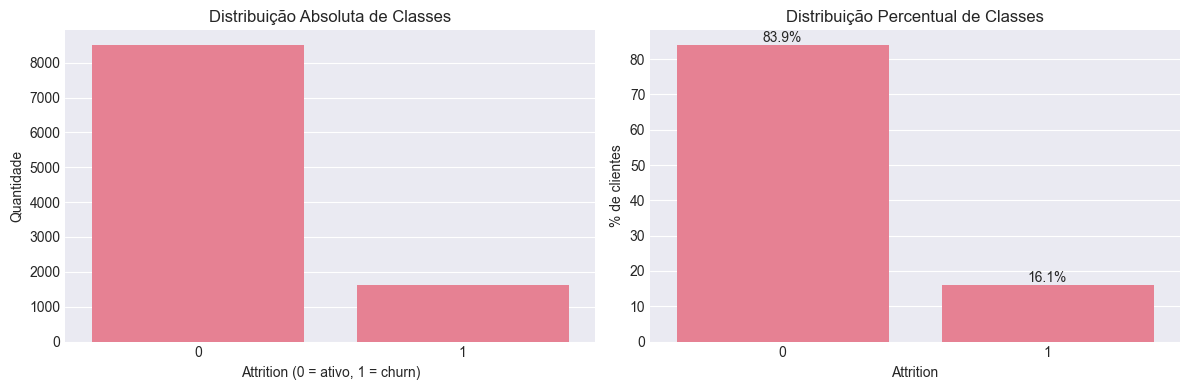


📌 Taxa de churn aproximada: 16.07%


In [6]:
if TARGET_COL in df.columns:
    churn_counts = df[TARGET_COL].value_counts().sort_index()
    churn_percent = churn_counts / churn_counts.sum() * 100

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.barplot(x=churn_counts.index, y=churn_counts.values, ax=ax[0])
    ax[0].set_title("Distribuição Absoluta de Classes")
    ax[0].set_xlabel("Attrition (0 = ativo, 1 = churn)")
    ax[0].set_ylabel("Quantidade")

    sns.barplot(x=churn_percent.index, y=churn_percent.values, ax=ax[1])
    ax[1].set_title("Distribuição Percentual de Classes")
    ax[1].set_xlabel("Attrition")
    ax[1].set_ylabel("% de clientes")

    for i, p in enumerate(ax[1].patches):
        ax[1].annotate(
            f"{churn_percent.values[i]:.1f}%",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()

    print("\n📌 Taxa de churn aproximada:",
          f"{churn_percent.loc[1]:.2f}%" if 1 in churn_percent.index else churn_percent)


 ## 6. Análise de Outliers (IQR)

In [7]:
outlier_summary = {}

for col in numeric_cols:
    outlier_summary[col] = detect_outliers_iqr(df, col)

outlier_df = pd.DataFrame(outlier_summary).T
outlier_df = outlier_df.sort_values("outlier_percentage", ascending=False)

print("Resumo de outliers (top 10):")
display(outlier_df.head(10))

significant_outliers = outlier_df[outlier_df["outlier_percentage"] > 1]
print("\nVariáveis com mais de 1% de outliers:", len(significant_outliers))
display(significant_outliers.head(15))


Resumo de outliers (top 10):


,outlier_count,outlier_percentage,lower_bound,upper_bound,Q1,Q3,IQR,min,max,mean,median
Ticket_Medio,1144.0,11.296534,20.571423,92.419824,47.514573,65.476673,17.962100,19.137931,190.193182,62.612717,55.794872
Credit_Limit,984.0,9.716599,-10213.750000,23836.250000,2555.000000,11067.500000,8512.500000,1438.300000,34516.000000,8631.953698,4549.000000
Avg_Open_To_Buy,963.0,9.509233,-11477.250000,22660.750000,1324.500000,9859.000000,8534.500000,3.000000,34516.000000,7469.139637,3474.000000
Gasto_Medio_Mensal,933.0,9.212995,-56.138945,259.861205,62.361111,141.361149,79.000038,10.000000,1256.846154,131.011977,105.800000
Total_Trans_Amt,896.0,8.847635,-1722.750000,8619.250000,2155.500000,4741.000000,2585.500000,510.000000,18484.000000,4404.086304,3899.000000
Contacts_Count_12_mon,629.0,6.211119,0.500000,4.500000,2.000000,3.000000,1.000000,0.000000,6.000000,2.455317,2.000000
Total_Amt_Chng_Q4_Q1,396.0,3.910339,0.289000,1.201000,0.631000,0.859000,0.228000,0.000000,3.397000,0.759941,0.736000
Total_Ct_Chng_Q4_Q1,394.0,3.890590,0.228000,1.172000,0.582000,0.818000,0.236000,0.000000,3.714000,0.712222,0.702000
Months_on_book,386.0,3.811593,17.500000,53.500000,31.000000,40.000000,9.000000,13.000000,56.000000,35.928409,36.000000
Months_Inactive_12_mon,331.0,3.268490,0.500000,4.500000,2.000000,3.000000,1.000000,0.000000,6.000000,2.341167,2.000000



Variáveis com mais de 1% de outliers: 11


,outlier_count,outlier_percentage,lower_bound,upper_bound,Q1,Q3,IQR,min,max,mean,median
Ticket_Medio,1144.0,11.296534,20.571423,92.419824,47.514573,65.476673,17.962100,19.137931,190.193182,62.612717,55.794872
Credit_Limit,984.0,9.716599,-10213.750000,23836.250000,2555.000000,11067.500000,8512.500000,1438.300000,34516.000000,8631.953698,4549.000000
Avg_Open_To_Buy,963.0,9.509233,-11477.250000,22660.750000,1324.500000,9859.000000,8534.500000,3.000000,34516.000000,7469.139637,3474.000000
Gasto_Medio_Mensal,933.0,9.212995,-56.138945,259.861205,62.361111,141.361149,79.000038,10.000000,1256.846154,131.011977,105.800000
Total_Trans_Amt,896.0,8.847635,-1722.750000,8619.250000,2155.500000,4741.000000,2585.500000,510.000000,18484.000000,4404.086304,3899.000000
Contacts_Count_12_mon,629.0,6.211119,0.500000,4.500000,2.000000,3.000000,1.000000,0.000000,6.000000,2.455317,2.000000
Total_Amt_Chng_Q4_Q1,396.0,3.910339,0.289000,1.201000,0.631000,0.859000,0.228000,0.000000,3.397000,0.759941,0.736000
Total_Ct_Chng_Q4_Q1,394.0,3.890590,0.228000,1.172000,0.582000,0.818000,0.236000,0.000000,3.714000,0.712222,0.702000
Months_on_book,386.0,3.811593,17.500000,53.500000,31.000000,40.000000,9.000000,13.000000,56.000000,35.928409,36.000000
Months_Inactive_12_mon,331.0,3.268490,0.500000,4.500000,2.000000,3.000000,1.000000,0.000000,6.000000,2.341167,2.000000


 ### Visualização dos principais outliers

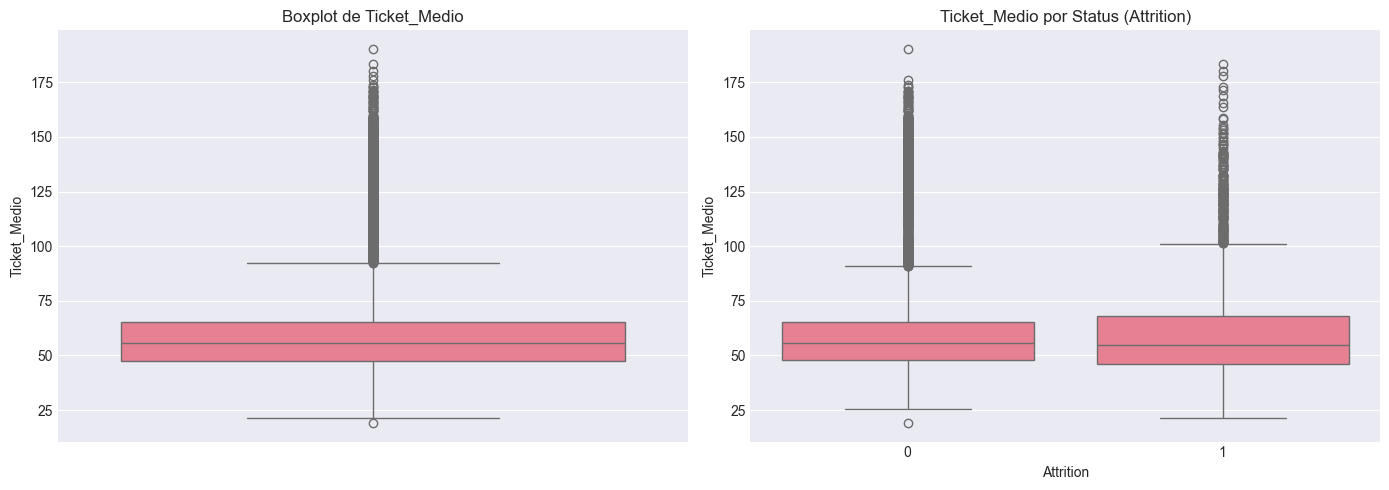


📈 Estatísticas de Ticket_Medio:
  outlier_count: 1144
  outlier_percentage: 11.296534017971759
  lower_bound: 20.57142253453106
  upper_bound: 92.41982396406837
  Q1: 47.514573070607554
  Q3: 65.47667342799188
  IQR: 17.96210035738433
  min: 19.13793103448276
  max: 190.1931818181818
  mean: 62.61271690294649
  median: 55.7948717948718


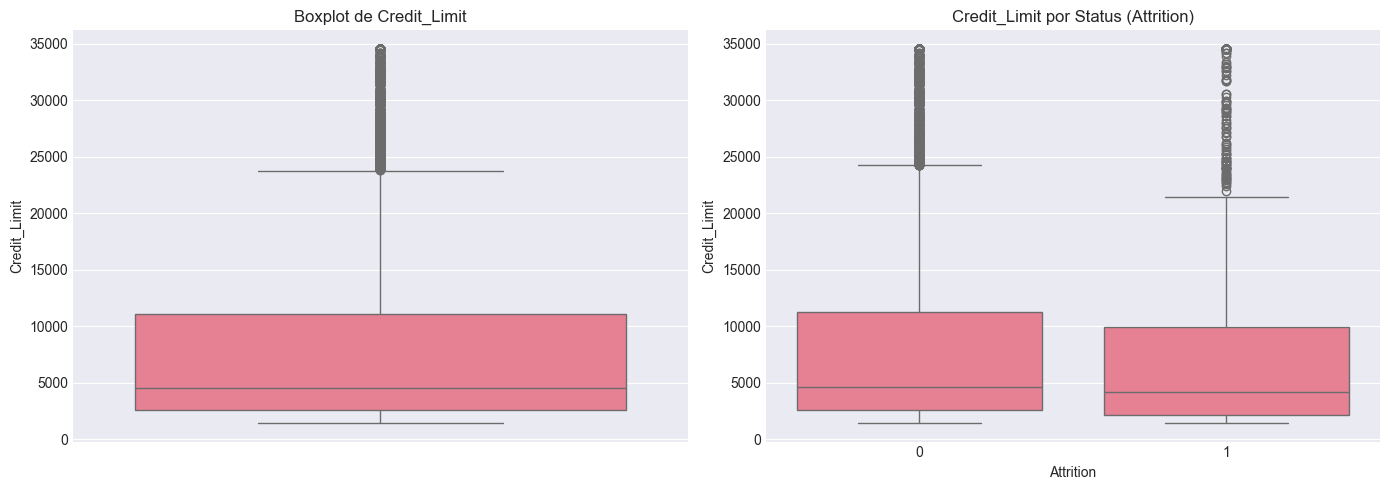


📈 Estatísticas de Credit_Limit:
  outlier_count: 984
  outlier_percentage: 9.7165991902834
  lower_bound: -10213.75
  upper_bound: 23836.25
  Q1: 2555.0
  Q3: 11067.5
  IQR: 8512.5
  min: 1438.3
  max: 34516.0
  mean: 8631.953698034955
  median: 4549.0


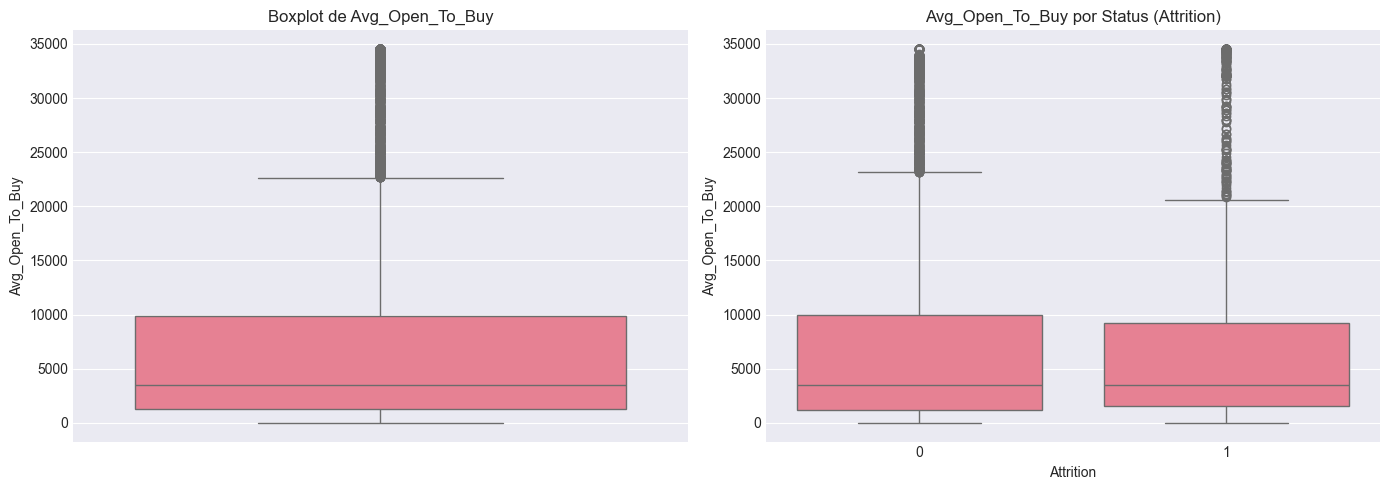


📈 Estatísticas de Avg_Open_To_Buy:
  outlier_count: 963
  outlier_percentage: 9.509232744149305
  lower_bound: -11477.25
  upper_bound: 22660.75
  Q1: 1324.5
  Q3: 9859.0
  IQR: 8534.5
  min: 3.0
  max: 34516.0
  mean: 7469.139636614989
  median: 3474.0


In [8]:
for col in significant_outliers.head(3).index:
    visualize_outliers(df, col, target_col=TARGET_COL, outlier_stats=outlier_summary)


 ### Outliers por classe (churn vs não churn)

In [9]:
if TARGET_COL in df.columns:
    outliers_by_class = {}

    for col in significant_outliers.head(5).index:
        churn_0 = df[df[TARGET_COL] == 0][col]
        churn_1 = df[df[TARGET_COL] == 1][col]

        stats_0 = detect_outliers_iqr(pd.DataFrame({col: churn_0}), col)
        stats_1 = detect_outliers_iqr(pd.DataFrame({col: churn_1}), col)

        outliers_by_class[col] = {
            "classe_0_pct": stats_0["outlier_percentage"],
            "classe_1_pct": stats_1["outlier_percentage"],
            "diferença": stats_1["outlier_percentage"] - stats_0["outlier_percentage"],
        }

    outliers_class_df = pd.DataFrame(outliers_by_class).T.sort_values(
        "diferença", ascending=False
    )

    print("Diferença na porcentagem de outliers entre classes:")
    display(outliers_class_df)


Diferença na porcentagem de outliers entre classes:


,classe_0_pct,classe_1_pct,diferença
Total_Trans_Amt,9.988235,19.360787,9.372551
Gasto_Medio_Mensal,10.517647,14.996927,4.479280
Avg_Open_To_Buy,9.152941,10.940381,1.787440
Ticket_Medio,10.964706,12.476951,1.512246
Credit_Limit,9.341176,10.633067,1.291891


 ## 7. Correlações com o Target e VIF

In [10]:
corr_results = significant_correlations(df, numeric_cols, target_col=TARGET_COL)
print("Top correlações (em valor absoluto) com Attrition:")
display(corr_results.head(15))

if HAS_STATSMODELS:
    try:
        vif_df = calculate_vif(df, numeric_cols)
        print("\nVIF (multicolinearidade) – top 15:")
        display(vif_df.head(15))
    except Exception as e:
        print("⚠️ Erro ao calcular VIF:", e)
else:
    print("⚠️ statsmodels não está instalado. Pulei o cálculo de VIF.")


Top correlações (em valor absoluto) com Attrition:


,feature,correlation,p_value,significant,abs_correlation
11,Total_Trans_Ct,-0.371403,0.000000e+00,True,0.371403
12,Total_Ct_Chng_Q4_Q1,-0.290054,1.647725e-195,True,0.290054
15,Transacoes_por_Mes,-0.287237,1.322787e-191,True,0.287237
7,Total_Revolving_Bal,-0.263053,6.630148e-160,True,0.263053
5,Contacts_Count_12_mon,0.204491,4.697490e-96,True,0.204491
13,Avg_Utilization_Ratio,-0.178410,3.357689e-73,True,0.178410
18,Disponibilidade_Relativa,0.178406,3.385578e-73,True,0.178406
17,Rotativo_Ratio,-0.178406,3.385578e-73,True,0.178406
10,Total_Trans_Amt,-0.168598,1.857439e-65,True,0.168598
4,Months_Inactive_12_mon,0.152449,1.032664e-53,True,0.152449



VIF (multicolinearidade) – top 15:


,feature,VIF
19,Disponibilidade_Relativa,inf
18,Rotativo_Ratio,inf
7,Credit_Limit,inf
8,Total_Revolving_Bal,inf
9,Avg_Open_To_Buy,inf
14,Avg_Utilization_Ratio,1.216403e+06
11,Total_Trans_Amt,5.365168e+01
17,Gasto_Medio_Mensal,3.237050e+01
16,Transacoes_por_Mes,3.073570e+01
12,Total_Trans_Ct,2.363970e+01


 ## 8. PCA 2D e 3D + Clusterização

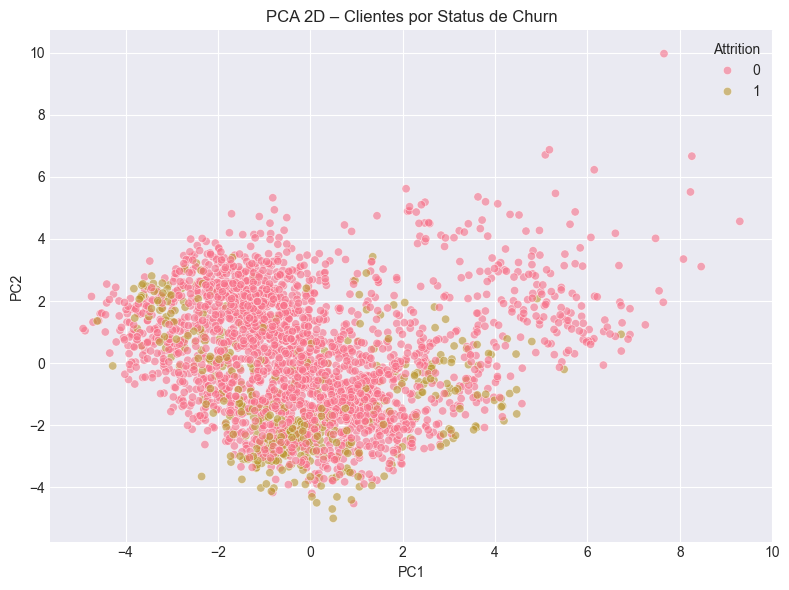

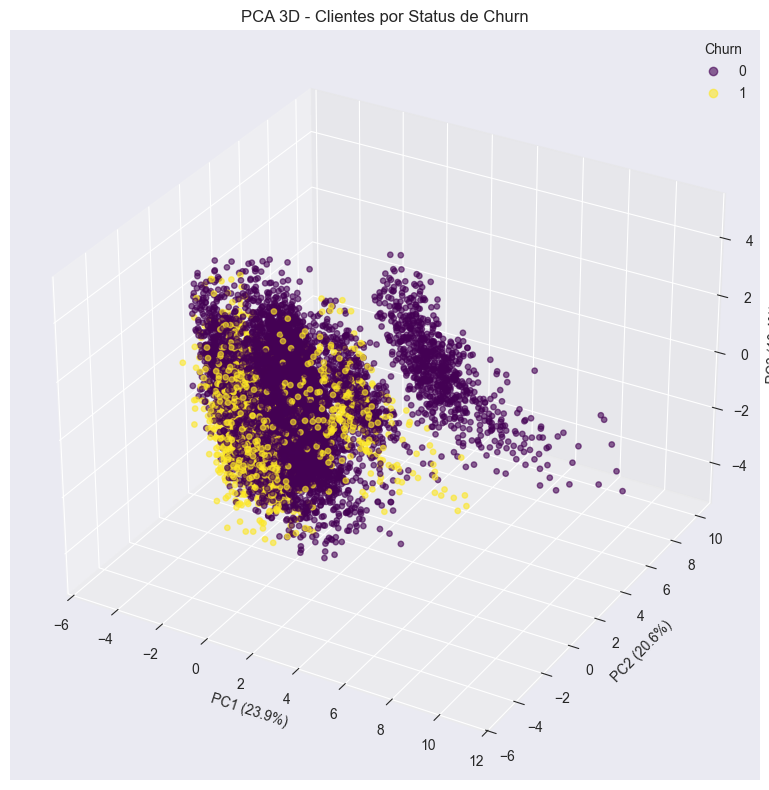

In [11]:
# Escalonar apenas variáveis numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])

# PCA 2D
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca_2d, columns=["PC1", "PC2"])
if TARGET_COL in df.columns:
    df_pca["Attrition"] = df[TARGET_COL]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_pca.sample(n=min(3000, len(df_pca)), random_state=42),
    x="PC1",
    y="PC2",
    hue="Attrition" if "Attrition" in df_pca.columns else None,
    alpha=0.6,
)
plt.title("PCA 2D – Clientes por Status de Churn")
plt.tight_layout()
plt.show()

# PCA 3D
if len(numeric_cols) >= 3:
    X_pca_3d, pca_model_3d = pca_3d_visualization(
        X_scaled,
        df[TARGET_COL] if TARGET_COL in df.columns else pd.Series([0] * len(df)),
    )
else:
    X_pca_3d, pca_model_3d = None, None
    print("PCA 3D não executado: menos de 3 variáveis numéricas.")


 ### Escolha de k com cotovelo e silhouette

  File "c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Iago\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Iago\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Iago\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


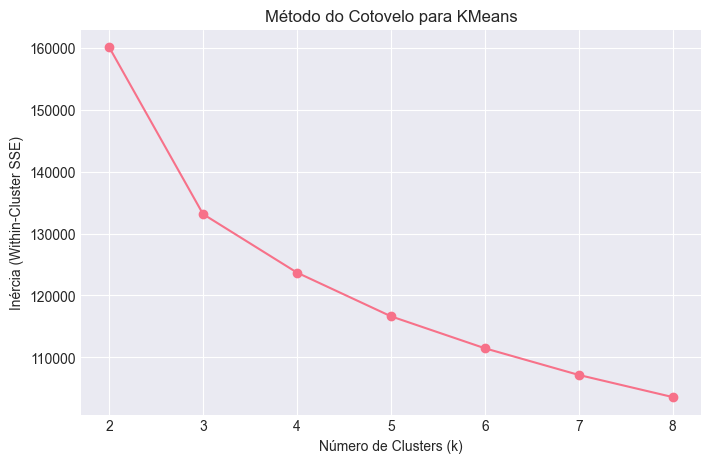

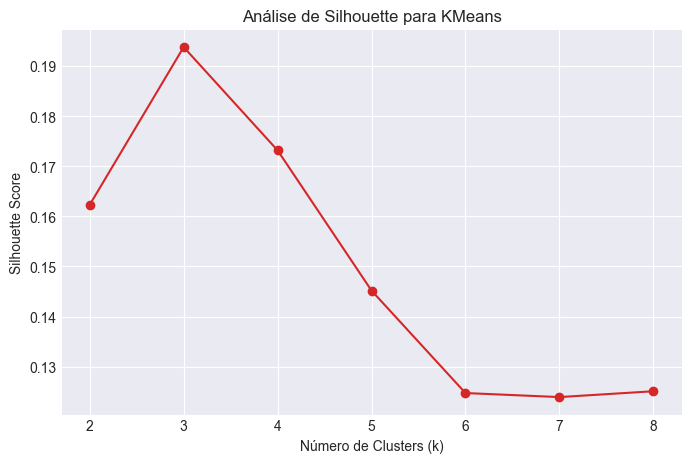

In [12]:
elbow_method(X_scaled, max_clusters=8)
silhouette_analysis(X_scaled, max_clusters=8)


 ### Clusterização com KMeans (k = 3)

In [13]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

df_clusters = df.copy()
df_clusters["Cluster"] = cluster_labels

cols_for_profile = numeric_cols.copy()
if TARGET_COL in df.columns:
    cols_for_profile.append(TARGET_COL)

cluster_profile = (
    df_clusters.groupby("Cluster")[cols_for_profile]
    .mean()
    .round(3)
)

print("Perfil médio dos clusters (variáveis numéricas + churn):")
display(cluster_profile)

if TARGET_COL in df.columns:
    cluster_churn = (
        df_clusters.groupby("Cluster")[TARGET_COL]
        .agg(["mean", "count"])
        .rename(columns={"mean": "taxa_churn", "count": "qtd_clientes"})
        .round(3)
    )
    print("\nTaxa de churn por cluster:")
    display(cluster_churn)


Perfil médio dos clusters (variáveis numéricas + churn):


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Ticket_Medio,Transacoes_por_Mes,Gasto_Medio_Mensal,Rotativo_Ratio,Disponibilidade_Relativa,Attrition
Cluster,,,,,,,,,,,,,,,,,,,,
0,46.686,2.377,36.387,4.046,2.380,2.572,10955.994,766.056,10189.938,0.747,3102.435,57.160,0.688,0.080,53.444,1.657,89.272,0.080,0.920,0.223
1,46.313,2.298,35.799,4.036,2.326,2.363,3007.055,1663.344,1343.710,0.769,3588.494,63.562,0.739,0.592,55.490,1.891,106.047,0.592,0.408,0.083
2,44.927,2.360,34.471,2.245,2.232,2.250,15361.437,1320.726,14040.711,0.784,11907.764,99.215,0.731,0.151,119.385,3.071,368.252,0.151,0.849,0.131



Taxa de churn por cluster:


,taxa_churn,qtd_clientes
Cluster,,
0,0.223,5155
1,0.083,3678
2,0.131,1294


 ## 9. Exportar Relatórios de EDA

In [14]:
eda_report = generate_eda_report(df, target_col=TARGET_COL)
with open(PROJECT_ROOT / "eda_report.json", "w", encoding="utf-8") as f:
    json.dump(eda_report, f, indent=4, ensure_ascii=False)
print("📁 Arquivo 'eda_report.json' salvo.")

export_analysis_results(
    df,
    cluster_labels=cluster_labels,
    pca_result=X_pca_2d,
    output_dir=PROJECT_ROOT / "eda_results",
)

print("✅ EDA concluída.")


📁 Arquivo 'eda_report.json' salvo.
✅ Resultados exportados para 'c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\eda_results/'
✅ EDA concluída.


 ## 10. Preparar Base Final de Modelagem



 Aqui removemos variáveis altamente multicolineares e adicionamos

 o rótulo de Cluster como feature categórica. Salvamos:



 - `data/base_modelagem.csv`

 - `data/features_modelagem.json`

In [15]:
# Colunas multicolineares para remover (redundantes entre si)
cols_to_drop = [
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Avg_Open_To_Buy",
    "Rotativo_Ratio",
    "Disponibilidade_Relativa",
]

df_model = df_clusters.drop(columns=[c for c in cols_to_drop if c in df_clusters.columns])

# Garante tipo inteiro da variável alvo
if TARGET_COL in df_model.columns:
    df_model[TARGET_COL] = df_model[TARGET_COL].astype(int)

# Definição das features numéricas e categóricas finais
NUM_FEATURES_MODEL = [
    "Customer_Age",
    "Dependent_count",
    "Months_on_book",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Trans_Amt",
    "Total_Trans_Ct",
    "Total_Ct_Chng_Q4_Q1",
    "Avg_Utilization_Ratio",
    "Ticket_Medio",
    "Transacoes_por_Mes",
    "Gasto_Medio_Mensal",
]

CAT_FEATURES_MODEL = [
    "Gender",
    "Education_Level",
    "Marital_Status",
    "Income_Category",
    "Card_Category",
    "Faixa_Idade",
    "Renda_Class",
    "Cluster",
]

# Salvar base de modelagem
OUTPUT_MODEL_PATH = PROJECT_ROOT / "data" / "base_modelagem.csv"
df_model.to_csv(OUTPUT_MODEL_PATH, index=False, encoding="utf-8")
print(f"✅ Base de modelagem salva em: {OUTPUT_MODEL_PATH}")

# Salvar features em JSON
features_info = {
    "numeric_features": NUM_FEATURES_MODEL,
    "categorical_features": CAT_FEATURES_MODEL,
    "target": TARGET_COL,
}

FEATURES_JSON_PATH = PROJECT_ROOT / "data" / "features_modelagem.json"
with open(FEATURES_JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(features_info, f, indent=4, ensure_ascii=False)

print(f"📁 Arquivo 'features_modelagem.json' salvo em: {FEATURES_JSON_PATH}")

print("\n✅ Pipeline de EDA + preparação de base de modelagem finalizado.")


✅ Base de modelagem salva em: c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\data\base_modelagem.csv
📁 Arquivo 'features_modelagem.json' salvo em: c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\data\features_modelagem.json

✅ Pipeline de EDA + preparação de base de modelagem finalizado.
